In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Ingest

In [2]:
# Import the wrangle function
from wrangle import wrangle

In [3]:
train, val, test = wrangle()
train.shape, val.shape, test.shape

((2550, 16), (850, 16), (850, 16))

In [4]:
train.head

<bound method NDFrame.head of      state  account_length      area_code international_plan voice_mail_plan  \
1023    KS             131  area_code_415                 no             yes   
440     AL              77  area_code_415                 no              no   
3560    UT              82  area_code_510                 no              no   
3660    KY              94  area_code_408                 no              no   
2337    IN             130  area_code_408                 no              no   
...    ...             ...            ...                ...             ...   
2793    MI             119  area_code_510                yes             yes   
3373    MO             137  area_code_510                 no              no   
2176    ND             104  area_code_415                 no              no   
1918    FL              97  area_code_415                 no             yes   
903     OH             114  area_code_415                 no              no   

      num

In [5]:
# This function will divide a dataframe into features and label
def feat_label_split(df, label):
    feat = df.drop(columns=[label])
    label = df[label]
    return feat, label

In [6]:
# apply the functioner
X_train, y_train = feat_label_split(train, 'churn')
X_val, y_val = feat_label_split(val, 'churn')
X_test, y_test = feat_label_split(test, 'churn')

In [7]:
X_train.shape, X_val.shape, X_test.shape

((2550, 15), (850, 15), (850, 15))

In [8]:
y_train.shape, y_val.shape, y_test.shape

((2550,), (850,), (850,))

## Preprocessing

In [9]:
# Numeric and categorical features
cat_cols = X_train.select_dtypes(include=['object']).columns.to_list()
num_cols = X_train.select_dtypes(include=['number']).columns.to_list()

In [10]:
print(f"Categorical columns are {cat_cols}")

Categorical columns are ['state', 'area_code', 'international_plan', 'voice_mail_plan']


In [11]:
print(f"Numeric columns are {num_cols}")

Numeric columns are ['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_eve_minutes', 'total_eve_calls', 'total_night_minutes', 'total_night_calls', 'total_intl_minutes', 'total_intl_calls', 'number_customer_service_calls']


In [12]:
assert 'churn' not in cat_cols, "The target variable is here"
assert 'churn' not in num_cols, "The target variable is here"

In [13]:
# Pipeline for numeric and categorical columns
cat_pipe = make_pipeline(
    OneHotEncoder(sparse_output=False)
)

num_pipe = make_pipeline(
    StandardScaler()
)

In [14]:
# Combine the pipelines with column transformer
preprocessing = ColumnTransformer(
    [
        ('num', num_pipe, num_cols),
        ('cats', cat_pipe, cat_cols)
    ]
)

In [15]:
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['account_length', 'number_vmail_messages',
                                  'total_day_minutes', 'total_day_calls',
                                  'total_eve_minutes', 'total_eve_calls',
                                  'total_night_minutes', 'total_night_calls',
                                  'total_intl_minutes', 'total_intl_calls',
                                  'number_customer_service_calls']),
                                ('cats',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['state', 'area_code', 'international_plan',
                                  'voice_mail_plan'])])

In [16]:
# Perform transformation on the train data
X_train_transformed = preprocessing.fit_transform(X_train)
X_train_transformed.shape

(2550, 69)

After the preprocessing, we'll end up with 69 columns

## Baseline Model

The most naive model i can think of is a model that only predicts one value i.e the most frequent class

In [17]:
# Instantiate a pipeline for Dummy classifier
dummy_pipeline = Pipeline([
    ('prep', preprocessing),
    ('dummy', DummyClassifier(strategy="most_frequent"))
])

In [18]:
# Fit to training data
dummy_pipeline.fit(X_train, y_train)
dummy_train_preds = dummy_pipeline.predict(X_train)

In [19]:
print(classification_report(y_train, dummy_train_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      2191
           1       0.00      0.00      0.00       359

    accuracy                           0.86      2550
   macro avg       0.43      0.50      0.46      2550
weighted avg       0.74      0.86      0.79      2550



The dummy classifier predicted only the majority class and the accuracy is 86%. 
This shows why accuracy is not useful here. 
The accuracy only reflected the majority class  in this context. 
However, we are more intrested in a model that can predicted churn

This is why we look to other metrics like precision, recall, as well as the confusion matrix

The precision, recall and f1score of the model on the model on the positive class above is 0 i.e useless

In [20]:
# Define a function to plot confusion matrix
def conf_mat(true, pred, figsize=(5, 3)):
    plt.figure(figsize=figsize)
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.xlabel("Predicted label")
    plt.ylabel('True label')
    plt.title('confusion matrix')
    return plt.show();

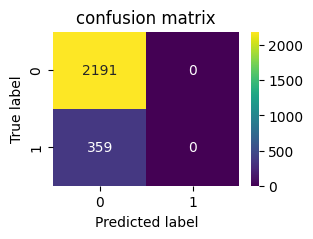

In [21]:
conf_mat(y_train, dummy_train_preds, figsize=(3, 2))

The confusion matrix helps to understand the types of error that a classification algorithm is making.  
The general idea of a confusion matrix is to count the number of times a class is correctly classified and incorrectly classified.  

As we can see, there are no predictions for churn i.e the model does not predict customer churn

## Decision Tree

In [22]:
# Instantiate a pipeline for trainining with a decison tree
tree_pipeline = Pipeline([
    ('prep', preprocessing),
    ('tree', DecisionTreeClassifier(random_state=42))
])

In [23]:
# Fit the model and make prediction on the training data
tree_pipeline.fit(X_train, y_train)
tree_train_preds = tree_pipeline.predict(X_train)

In [24]:
# Get the classification report
print(classification_report(y_train, tree_train_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2191
           1       1.00      1.00      1.00       359

    accuracy                           1.00      2550
   macro avg       1.00      1.00      1.00      2550
weighted avg       1.00      1.00      1.00      2550



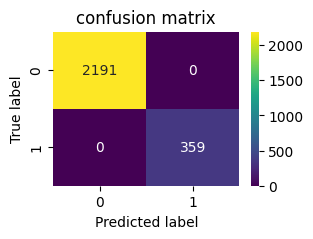

In [25]:
conf_mat(y_train, tree_train_preds, figsize=(3, 2))

Test the model on the validation set

In [26]:
# Get validation predictions
tree_val_preds = tree_pipeline.predict(X_val)

In [27]:
print(classification_report(y_val, tree_val_preds))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       731
           1       0.71      0.73      0.72       119

    accuracy                           0.92       850
   macro avg       0.83      0.84      0.84       850
weighted avg       0.92      0.92      0.92       850



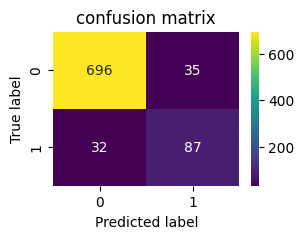

In [28]:
conf_mat(y_val, tree_val_preds, figsize=(3, 2))

The positive class has .71 precision and .72 recall.
The training set has perfect scores for all. 

The is a classic case of overfitting, this is expected of decision trees

In [29]:
tree_pipeline.named_steps['tree'].get_depth()

22

Our maximum depth is 22. We need to reduce it

perform hyperparameter tuning on max depth

In [30]:
# List some hyperparameters for max depth
depth_hyperparams = range(1, 23, 2)

In [31]:
%%time

# Create empty lists for training and validation accuracy scores
training_f1 = []
validation_f1 = []
training_rec = []
validation_rec = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    pipe = Pipeline([
        ('prep', preprocessing),
        ('tree', DecisionTreeClassifier(max_depth=d, random_state=42))
    ])
    # Fit model to training data
    pipe.fit(X_train, y_train)
    # train_preds
    train_preds = pipe.predict(X_train)
    # val_perds
    val_preds = pipe.predict(X_val)
    # Training f1 score and recall score
    training_f1.append(f1_score(y_train, train_preds, zero_division=0))
    training_rec.append(recall_score(y_train, train_preds, zero_division=0))
    # Validation f1 score and recall score
    validation_f1.append(f1_score(y_val, val_preds, zero_division=0))
    validation_rec.append(recall_score(y_val, val_preds, zero_division=0))
    
print("Training f1 Scores:", training_rec[:3])
print("Validation f1 Scores:", validation_rec[:3])

Training f1 Scores: [0.28690807799442897, 0.4373259052924791, 0.7520891364902507]
Validation f1 Scores: [0.2184873949579832, 0.3445378151260504, 0.6974789915966386]
CPU times: user 774 ms, sys: 45.9 ms, total: 820 ms
Wall time: 820 ms


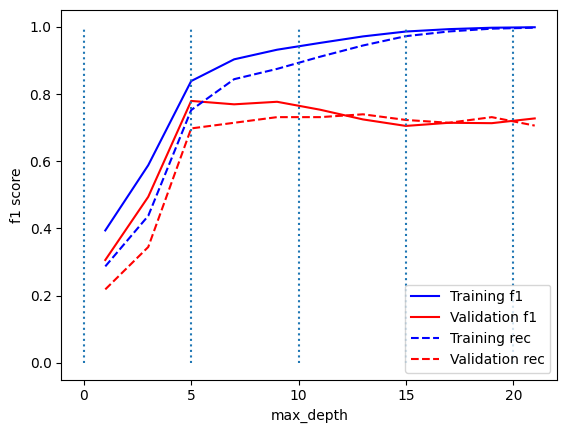

In [32]:
# Plot `depth_hyperparams`, `training_recall`, training f1 score

plt.plot(depth_hyperparams, training_f1, label='Training f1', c='b')
plt.plot(depth_hyperparams, validation_f1, label='Validation f1', c='r')
plt.plot(depth_hyperparams, training_rec, label='Training rec', c='b', linestyle='dashed')
plt.plot(depth_hyperparams, validation_rec, label='Validation rec', c='r', linestyle='dashed')
plt.vlines(range(0, 21, 5), 0, 1, linestyles='dotted')
plt.xlabel('max_depth')
plt.ylabel('f1 score')
plt.legend();

The optimal max_depth is 5

In [33]:
# Instantiate a new pipeline to train the final model
final_pipe = Pipeline([
        ('prep', preprocessing),
        ('tree', DecisionTreeClassifier(max_depth=5, random_state=42))
    ])

In [34]:
# Fit the model
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['account_length',
                                                   'number_vmail_messages',
                                                   'total_day_minutes',
                                                   'total_day_calls',
                                                   'total_eve_minutes',
                                                   'total_eve_calls',
                                                   'total_night_minutes',
                                                   'total_night_calls',
                                                   'total_intl_minutes',
                                                   'total_intl_calls',
                                                   'number_customer_service_calls']),
                                                 ('cats',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['state', 'area_code',
                                                   'international_plan',
                                                   'voice_mail_plan'])])),
                ('tree', DecisionTreeClassifier(max_depth=5, random_state=42))])

In [35]:
# Make predictions on the training and validation score
train_preds = final_pipe.predict(X_train)
val_preds = final_pipe.predict(X_val)

In [36]:
# Classification report train dataset
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2191
           1       0.95      0.75      0.84       359

    accuracy                           0.96      2550
   macro avg       0.95      0.87      0.91      2550
weighted avg       0.96      0.96      0.96      2550



In [37]:
# Classification report validatiaon dataset
print(classification_report(y_val, val_preds))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       731
           1       0.88      0.70      0.78       119

    accuracy                           0.94       850
   macro avg       0.92      0.84      0.87       850
weighted avg       0.94      0.94      0.94       850



The recall are 75% on train and 70% on validation set

In [38]:
# Evaluate the model based on the test set
test_preds = final_pipe.predict(X_test)

In [39]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       730
           1       0.84      0.62      0.71       120

    accuracy                           0.93       850
   macro avg       0.89      0.80      0.84       850
weighted avg       0.93      0.93      0.92       850



The recall value was further reduced to 62% on the test set. This is not unexpected as it junped from 75% on the training set to 70% on the valication set

## Communication

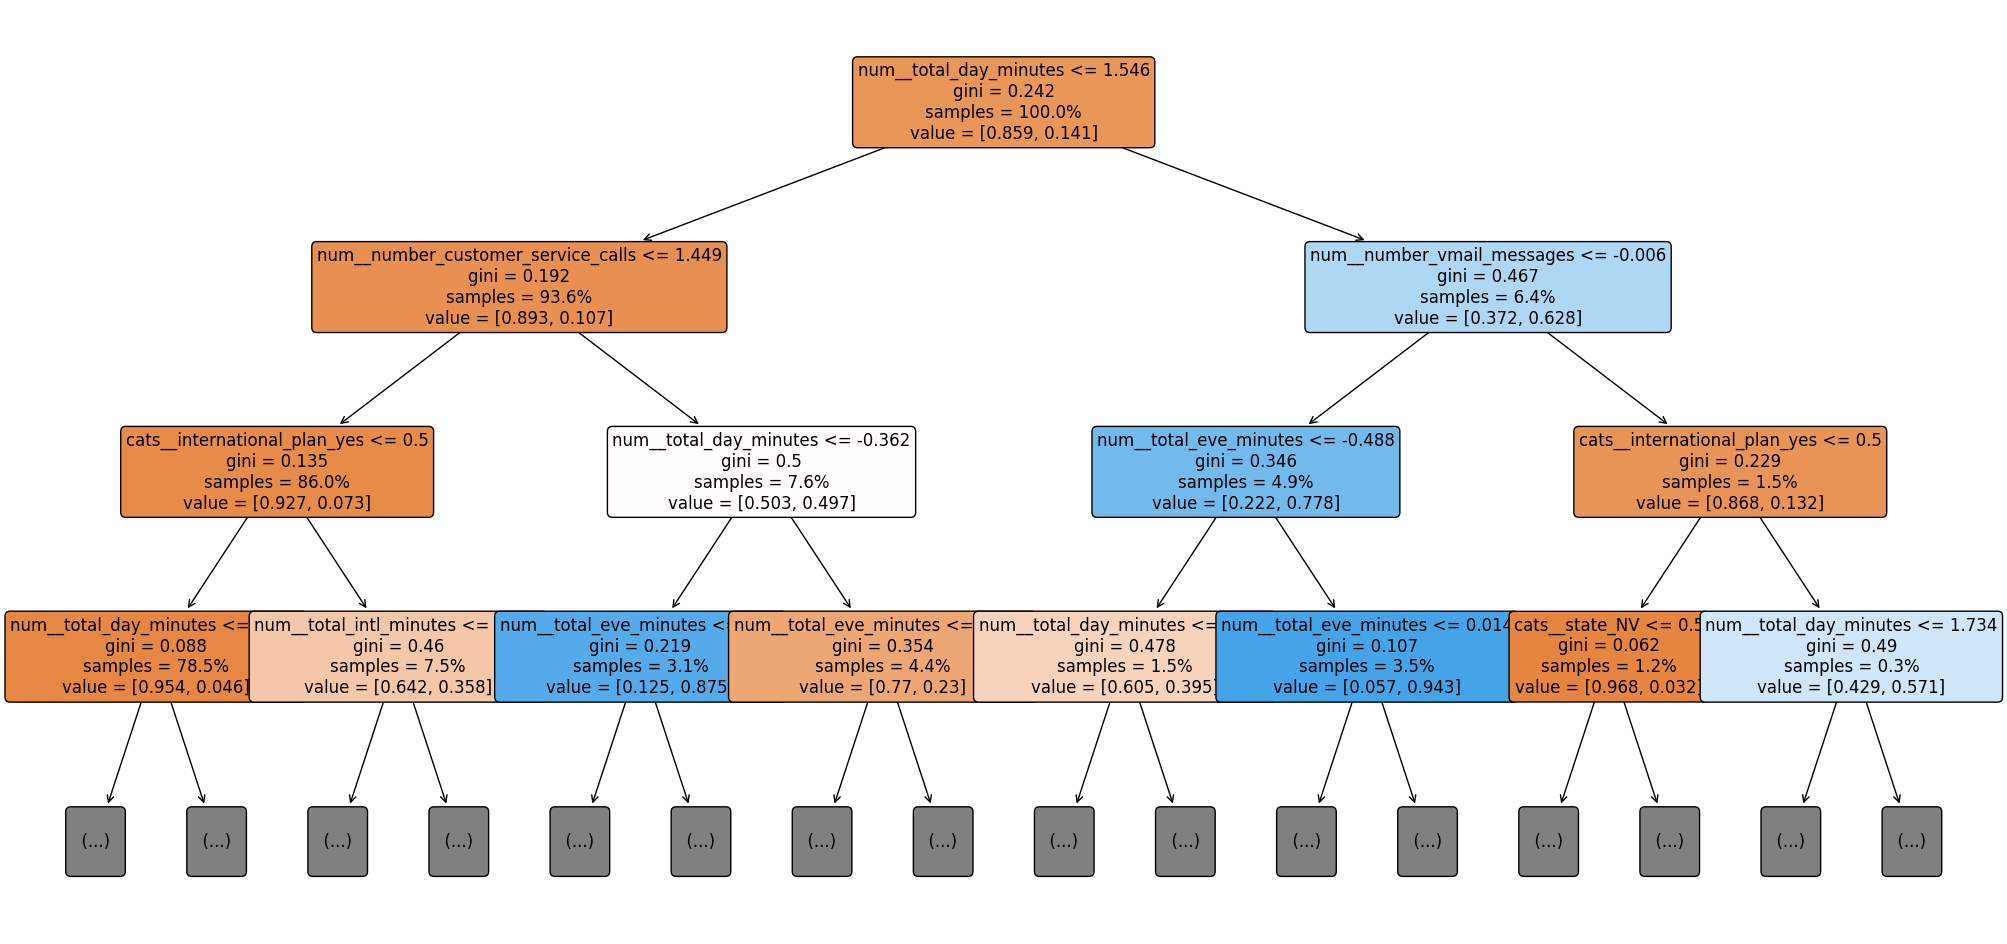

In [40]:
# Plot the decision tree
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=final_pipe.named_steps['tree'],
    feature_names=list(final_pipe.named_steps['prep'].get_feature_names_out()),
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

The model considers teh most important feature to be total_day_minutes i.e total number of minutes that a customer called diring the day

Get feature importances i.e the hierarchy of important features accordint to the model

In [41]:
# Feature names 
features = final_pipe.named_steps['prep'].get_feature_names_out()
# Feature importance
importances = final_pipe.named_steps['tree'].feature_importances_

print("Features:", features[:5])
print("Importances:", importances[:3])

Features: ['num__account_length' 'num__number_vmail_messages'
 'num__total_day_minutes' 'num__total_day_calls' 'num__total_eve_minutes']
Importances: [0.         0.05645901 0.37171574]


In [42]:
# JOin them in a series
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head()

num__account_length    0.0
cats__state_MO         0.0
cats__state_MS         0.0
cats__state_MT         0.0
cats__state_NC         0.0
dtype: float64

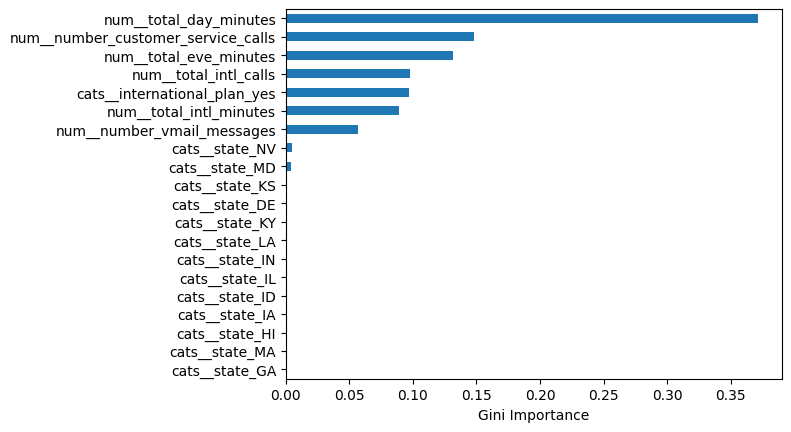

In [43]:
# Create horizontal bar chart
feat_imp.tail(20).plot(kind="barh")
plt.xlabel('Gini Importance');

The model determined that ther are only 9 important features in the dataset. 

+ total_day_minutes, numerical. Total minutes of day calls.
+ number_customer_service_calls, numerical. Number of calls to customer service
+ total_eve_minutes, numerical. Total minutes of evening calls.
+ total_intl_calls, numerical. Total number of international calls.
+ international_plan   - yes  i.e if you have an international plan
+ total_intl_minutes, numerical. Total minutes of international calls.
+ number_vmail_messages, numerical. Number of voice-mail messages.
+ state ==  MD
+ state == MD